Collab Link : https://colab.research.google.com/drive/10x0c8hQZ_ZSyoGx0_upC9eCSb4pIweha?usp=sharing

# The notebook Contains code for Evaluating the fine tuned BERT model for paraphrase identification task

# Imports

In [ ]:
!pip install --quiet transformers
!pip install --quiet tokenizers
!pip install --quiet sentencepiece
!pip install --quiet torchtext torch
!pip install --quiet pytorch_lightning

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 59 kB 4.9 MB/s 
     |████████████████████████████████| 895 kB 31.5 MB/s 
     |████████████████████████████████| 3.3 MB 33.3 MB/s 
     |████████████████████████████████| 596 kB 41.3 MB/s 
     |████████████████████████████████| 1.2 MB 5.4 MB/s 
     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 132 kB 45.2 MB/s 
     |████████████████████████████████| 829 kB 38.0 MB/s 
     |████████████████████████████████| 329 kB 44.3 MB/s 
     |████████████████████████████████| 1.1 MB 43.8 MB/s 
     |████████████████████████████████| 192 kB 47.1 MB/s 
     |████████████████████████████████| 271 kB 39.4 MB/s 
     |████████████████████████████████| 160 kB 34.4 MB/s 


In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel
import pytorch_lightning as pl

from pytorch_lightning.plugins import DDPPlugin

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix , confusion_matrix
from sklearn.metrics import accuracy_score,f1_score,roc_curve , auc , RocCurveDisplay
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
%mv "/content/drive/MyDrive/Colab Notebooks/Evaluation_BERT_Paraphrase_Identification.ipynb" "/content/drive/MyDrive/IRE/Paraphrase-Identification-and-Generation/Models/BERT_Classifier"

## The classifier

### The model class

In [ ]:
class BertParaphrase(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.model =  BertModel.from_pretrained( 'bert-base-cased' ,return_dict=True)
    self.classifier = nn.Linear(self.model.config.hidden_size, 1)
    self.criterion = nn.BCELoss()
    self.relu = nn.ReLU()
    self.layer_1 = nn.Linear(self.model.config.hidden_size , self.model.config.hidden_size)

  def forward(self, input_ids, attention_mask, labels=None):
  
    output = self.model(input_ids, attention_mask=attention_mask)
    output = self.layer_1(output.pooler_output)
    output = self.relu(output)
    output = self.classifier(output)
    output = torch.sigmoid(output)
    
    loss = 0

    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

### Tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Loading the model

In [ ]:
bert_model = BertParaphrase.load_from_checkpoint("./drive/MyDrive/IRE/Pytorch_Paraphrase_Identification_Paws/lightning_logs/paraphrase-identification/version_0/checkpoints/epoch=3-step=2683.ckpt")
bert_model.to("cuda")
bert_model.eval()
bert_model.freeze()


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Testing Data

In [ ]:
test_df = pd.read_csv("../../PAWS_dataset/paws_test.csv")

In [ ]:
test_sentence = test_df.iloc[10]['sentence1']
test_paraphrase = test_df.iloc[10]['sentence2']
test_label = test_df.iloc[10]['label']
print(test_sentence)
print(test_paraphrase)
print(test_label)

test_encoding = tokenizer.encode_plus(
  test_sentence,
  test_paraphrase,
  add_special_tokens=True,
  max_length=120,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = bert_model(test_encoding["input_ids"].to("cuda"), test_encoding["attention_mask"].to("cuda"))

print(test_prediction)

The grass grows in the Masirah Channel , a waterway between Masirah Island and mainland Oman , where it is an important food for the green sea turtle .
The grass grows in the Masirah Channel , a waterway between Masirah Island and the mainland Oman , where it is an important food for the green sea turtle .
1
tensor([[0.9729]], device='cuda:0')


## Getting the prediction

In [ ]:
def get_prediction(trained_model , sentence , paraphrase):
  enc = tokenizer.encode_plus(
      sentence,
      paraphrase,
      add_special_tokens=True,
      max_length=120,
      return_token_type_ids=False,
      padding="max_length",
      return_attention_mask=True,
      return_tensors='pt',
    )
  
  _,prediction = trained_model(enc["input_ids"].to("cuda"), enc["attention_mask"].to("cuda"))
  prediction = prediction.flatten().cpu().numpy()
  pred_label = prediction[0] > 0.8
  pred_label = pred_label * 1
  return pred_label

In [ ]:
preds = []
true_labels = []

for _,row in tqdm(list(test_df.iterrows())):
  pred = get_prediction(bert_model , row['sentence1'] , row['sentence2'])
  true_labels.append(row['label'])
  preds.append(pred)

100%|██████████| 11000/11000 [04:48<00:00, 38.10it/s]


### Accuracy

In [ ]:
print("ACCURACY IS " , accuracy_score(true_labels , preds) * 100 , "%")

ACCURACY IS  89.0 %


### F1 Score

F1 SCORE IS  88.07411787896709 %
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      5964
           1       0.87      0.89      0.88      5036

    accuracy                           0.89     11000
   macro avg       0.89      0.89      0.89     11000
weighted avg       0.89      0.89      0.89     11000



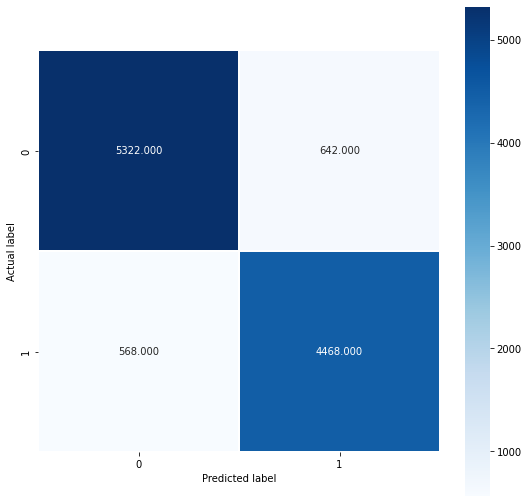

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
print("F1 SCORE IS " , f1_score(true_labels , preds) * 100 , "%")
print(classification_report(true_labels , preds))

plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix(true_labels , preds) , annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.show()

### ROC_AUC

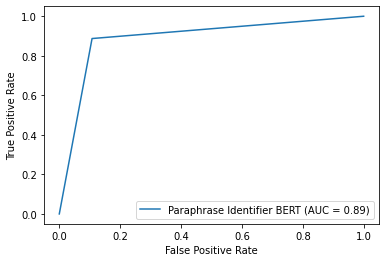

In [ ]:
fpr, tpr, thresholds = roc_curve(true_labels, preds)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='Paraphrase Identifier BERT')
display.plot()
plt.show()

### Sample predictions

In [ ]:
import random

In [ ]:
indices = random.sample(range(len(test_df)) , 5000)
print(indices[:50])

[419, 5254, 5519, 6253, 7934, 7793, 9225, 5446, 9952, 3361, 660, 3888, 4708, 6110, 4759, 4234, 10497, 575, 8328, 10820, 2751, 5075, 3875, 8429, 151, 812, 5926, 5306, 1956, 2123, 1588, 8381, 9157, 435, 2724, 2305, 6137, 6073, 7628, 2451, 8960, 6779, 10681, 2083, 7988, 216, 5049, 8721, 6320, 2796]


In [ ]:
print("PARAPHRASES CORRECTLY LABELLED")
sents = []
paras = []
labs = []
predicted = []
for ind in indices:
  if preds[ind] == true_labels[ind] and true_labels[ind] == 1:
    sents.append(test_df.iloc[ind]['sentence1'])
    paras.append(test_df.iloc[ind]['sentence2'])
    labs.append(test_df.iloc[ind]['label'])
    predicted.append(preds[ind])


for i in range(50):
  print("SENTENCE : " , sents[i])
  print("PARAPHRASE: " , paras[i])
  print("LABEL: " , labs[i])
  print("PREDICTED: ",predicted[i])
  print()
  print("-------")

PARAPHRASES CORRECTLY LABELLED
SENTENCE :  The head of the college is Steve Marshall and the assistant manager is Danny Hubball .
PARAPHRASE:  The head of the college is Steve Marshall and the assistant head is Danny Hubball .
LABEL:  1
PREDICTED:  1

-------
SENTENCE :  The exhibition was opened by Séamus Hegarty , the bishop of Derry , a former student and former patron of school .
PARAPHRASE:  The exhibition was opened by Séamus Hegarty , the bishop of Derry , a former student and former patron of school .
LABEL:  1
PREDICTED:  1

-------
SENTENCE :  Baako had four children , one of whom is Kweku Baako Jnr , a journalist and publisher of the newspaper `` New Crusading Guide '' .
PARAPHRASE:  Baako had four children . One of them , Kweku Baako Jnr is a journalist and editor of the `` New Crusading Guide '' newspaper .
LABEL:  1
PREDICTED:  1

-------
SENTENCE :  The layout of Davey Glen Park is similar to that of Twin Pines park and other parks in Belmont .
PARAPHRASE:  The layout of

In [ ]:
print("NON-PARAPHRASES CORRECTLY LABELLED")
sents = []
paras = []
labs = []
predicted = []
for ind in indices:
  if preds[ind] == true_labels[ind] and true_labels[ind] == 0:
    sents.append(test_df.iloc[ind]['sentence1'])
    paras.append(test_df.iloc[ind]['sentence2'])
    labs.append(test_df.iloc[ind]['label'])
    predicted.append(preds[ind])


for i in range(50):
  print("SENTENCE : " , sents[i])
  print("PARAPHRASE: " , paras[i])
  print("LABEL: " , labs[i])
  print("PREDICTED: ",predicted[i])
  print()
  print("-------")

NON-PARAPHRASES CORRECTLY LABELLED
SENTENCE :  It runs through Forest Park , along the north side of the Highland Park and through Ridgewood Reservoir .
PARAPHRASE:  It runs through Highland Park , along the north side of Ridgewood Reservoir , and through Forest Park .
LABEL:  0
PREDICTED:  0

-------
SENTENCE :  Since then , Lucki has worked with prominent music figures and published songs with chance the rapper , FKA Twigs and Danny Brown songs .
PARAPHRASE:  Since then Danny Brown has worked with prominent music figures and has published songs with chance the rapper , FKA Twigs and Lucki .
LABEL:  0
PREDICTED:  0

-------
SENTENCE :  In 2006 , the Álvarez won the South America Games against Hamilton Ventura .
PARAPHRASE:  Hamilton Ventura has won the South America Games in 2006 against Álvarez .
LABEL:  0
PREDICTED:  0

-------
SENTENCE :  Which is best site to learn data strucure with c?
PARAPHRASE:  Which is best site to learn data strucure?
LABEL:  0
PREDICTED:  0

-------
SENTEN

In [ ]:
print("INCORRECTLY LABELLED")
sents = []
paras = []
labs = []
predicted = []
for ind in indices:
  if preds[ind] != true_labels[ind]:
    sents.append(test_df.iloc[ind]['sentence1'])
    paras.append(test_df.iloc[ind]['sentence2'])
    labs.append(test_df.iloc[ind]['label'])
    predicted.append(preds[ind])


for i in range(100):
  print("SENTENCE : " , sents[i])
  print("PARAPHRASE: " , paras[i])
  print("LABEL: " , labs[i])
  print("PREDICTED: ",predicted[i])
  print()
  print("-------")

INCORRECTLY LABELLED
SENTENCE :  How does Jimmy Wales make money?
PARAPHRASE:  How does Jimmy Wales make money, if he is not earning any money from Wikipedia? Does he have a side business?
LABEL:  1
PREDICTED:  0

-------
SENTENCE :  How do we perceive the world?
PARAPHRASE:  Is what we perceive, the world?
LABEL:  0
PREDICTED:  1

-------
SENTENCE :  The most common partnerships were : Britain : Beasley & Sir George Morris ; Guy Domville & Graham Mathieson ; Lady Doris Rhodes & Percy Tabbush .
PARAPHRASE:  The most frequent partnerships were : Britain : Beasley , Sir Guy Domville , George Morris , Percy Tabbush , Lady Doris Rhodes , Graham Mathieson .
LABEL:  0
PREDICTED:  1

-------
SENTENCE :  I am an introvert. How can I control my emotions in a better way?
PARAPHRASE:  How do I control emotions and reactions in nervousness?
LABEL:  1
PREDICTED:  0

-------
SENTENCE :  `` Madang '' was commissioned by Evans Deakin in Brisbane , Queensland , on August 10 , 1968 , and launched on Nov